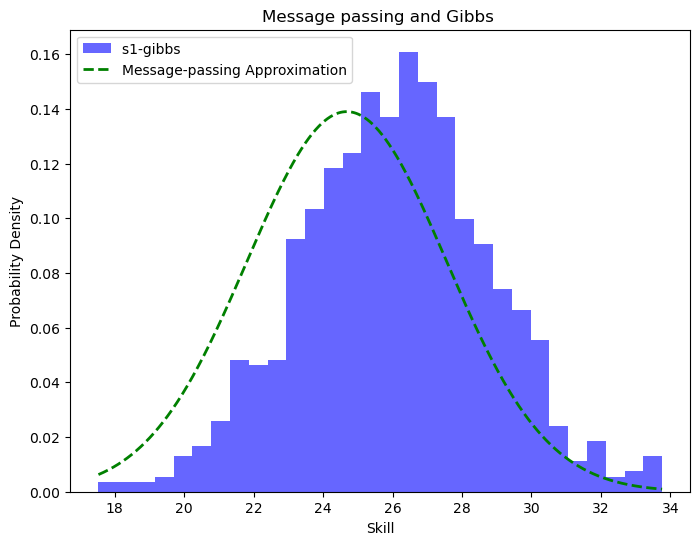

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm, norm

# Moment matching for truncated Gaussian(p(t|y))
def moment_matching_truncated_gaussian(mu, sigma, y):
    if y == 1:
        a, b = 0, np.inf  
    else:
        a, b = -np.inf, 0  

    trunc_mean = truncnorm.mean(a=(a - mu) / sigma, b=(b - mu) / sigma, loc=mu, scale=sigma) #truncated mean
    trunc_var = truncnorm.var(a=(a - mu) / sigma, b=(b - mu) / sigma, loc=mu, scale=sigma) #truncated variance
    
    return trunc_mean, trunc_var

def message_passing(mu_s1, sigma_s1, mu_s2, sigma_s2, sigma_t, y):
    #  Compute (t)
    mu_t = mu_s1 - mu_s2
    sigma_t_combined = np.sqrt(sigma_s1**2 + sigma_s2**2 + sigma_t**2)
    
    # moment matching for (p(t|y))
    mu_t_post, sigma_t_post = moment_matching_truncated_gaussian(mu_t, sigma_t_combined, y)
    
    #skills update
    sigma_s1_post = np.sqrt(1 / (1 / sigma_s1**2 + 1 / sigma_t_post**2))
    mu_s1_post = sigma_s1_post**2 * (mu_s1 / sigma_s1**2 + mu_t_post / sigma_t_post**2)
    
    sigma_s2_post = np.sqrt(1 / (1 / sigma_s2**2 + 1 / sigma_t_post**2))
    mu_s2_post = sigma_s2_post**2 * (mu_s2 / sigma_s2**2 - mu_t_post / sigma_t_post**2)
    
    return (mu_s1_post, sigma_s1_post), (mu_s2_post, sigma_s2_post)

def conditional_outcome(s1, s2, result, sigma_t):
    mean_diff = s1 - s2
    std_diff = sigma_t

    if result == 1:
        a, b = 0, np.inf  
    else:
        a, b = -np.inf, 0  

    a_std = (a - mean_diff) / std_diff
    b_std = (b - mean_diff) / std_diff

    return a_std, b_std, mean_diff, std_diff  


def gibbs_sampler_result(mu_s1, mu_s2, sigma_s1, sigma_s2, sigma_t, n_iter, result):
    s1_samples = np.zeros(n_iter)
    s2_samples = np.zeros(n_iter)
    t_samples = np.zeros(n_iter)
    
    s1_current = mu_s1
    s2_current = mu_s2

    mu_prior = np.array([mu_s1, mu_s2]).reshape((2, 1))
    sigma_prior = np.array([[sigma_s1, 0], [0, sigma_s2]])
    sigma_prior_inv = np.linalg.inv(sigma_prior)

    A = np.array([1, -1]).reshape((1, 2))
    A_T = A.T

    for i in range(n_iter):
        a_std, b_std, mean_diff, std_diff = conditional_outcome(s1_current, s2_current, result, sigma_t)
        t_current = truncnorm.rvs(a=a_std, b=b_std, loc=mean_diff, scale=std_diff)
        sigma_post = np.linalg.inv(sigma_prior_inv + (A_T @ A) / sigma_t**2)
        mu_post = sigma_post @ (sigma_prior_inv @ mu_prior + (A_T * t_current) / sigma_t**2)
        s1_current, s2_current = np.random.multivariate_normal(mu_post.flatten(), sigma_post)
        s1_samples[i] = s1_current
        s2_samples[i] = s2_current
        t_samples[i] = t_current

    return s1_samples, s2_samples, t_samples

def plot_comparison(s1_samples, mu_s1_post, sigma_s1_post):
    plt.figure(figsize=(8, 6))
    
    # Plot for Gibbs (s1)
    plt.hist(s1_samples, bins=30, density=True, alpha=0.6, color='blue', label='s1-gibbs ')
    x = np.linspace(min(s1_samples), max(s1_samples), 1000)
    #plt.plot(x, norm.pdf(x, np.mean(s1_samples), np.std(s1_samples)), 'r-', lw=2, label='Gaussian Distribution')
    
    # Plot for message-passing (s1)
    plt.plot(x, norm.pdf(x, mu_s1_post, np.sqrt(sigma_s1_post)), 'g--', lw=2, label='Message-passing Approximation')

    plt.title('Message passing and Gibbs ')
    plt.xlabel('Skill')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.show()

# test
if __name__ == "__main__":
    mu_s1, sigma_s1 = 25, 8.33  
    mu_s2, sigma_s2 = 25, 8.33  
    sigma_t = 25 / 6 
    y = 1  
    n_iter = 1000  

    # Run Gibbs 
    s1_samples, s2_samples, _ = gibbs_sampler_result(mu_s1, mu_s2, sigma_s1, sigma_s2, sigma_t, n_iter, y)

    # Run message-passing a
    message_passing_results = message_passing(mu_s1, sigma_s1, mu_s2, sigma_s2, sigma_t,y)
    mu_s1_post, sigma_s1_post = message_passing_results[0]

    # Compare and plot the results for s1
    plot_comparison(s1_samples, mu_s1_post, sigma_s1_post)
